In [1]:
from dqn import CarRacingAgent
import gym
from collections import deque
import cv2 as cv
import numpy as np

import warnings
warnings.filterwarnings('ignore')

### Hyperparameters

In [2]:

START_EPISODE = 0
END_EPISODE = 4000
SKIP_FRAMES = 2
BATCH_SIZE = 32
SAVE_MODEL_EVERY = 25
UPDATE_TARGET_MODEL_EVERY = 5
NEGATIVE_REWARD_TOLERANCE_WINDOW = 50
NEGATIVE_REWARD_TOLERANCE_LIMIT = 25

CONTINUE_TRAINING = False

folder_name = './overnightRun/'
SAVE_MODEL_PATH = './overnightRun/episode_{}.h5'

# create directory to save models
import os
if not os.path.exists(folder_name):
    os.makedirs(folder_name)

In [3]:
#env = gym.make('CarRacing-v2', render_mode='human')
RENDER = False
env = gym.make('CarRacing-v2')

In [4]:

rewards_over_episodes = []
average_rewards = []
epsilon_values = []
if CONTINUE_TRAINING:
    agent = CarRacingAgent()
    agent.model.load_weights(folder_name + 'episode_{}.h5'.format(START_EPISODE))
    with open(folder_name + f'episode_{START_EPISODE}.txt', 'r') as f:
        data = eval(f.read())
        rewards_over_episodes = data['rewards_over_episodes']
        epsilon_values = data['epsilon_values']
else:
    agent = CarRacingAgent()

In [5]:
def process_state(state):
    state = cv.cvtColor(state, cv.COLOR_RGB2GRAY)
    state = state.astype(np.float32)
    state /= 255.0
    return state

def save(episode, rewards_over_episodes):
    data = {
        'rewards_over_episodes': rewards_over_episodes,
        **agent.get_params()
    }
    h5file = folder_name + f'{episode}.h5'
    data_file_path = folder_name + f'episode_{episode}.txt'
    data_file = open(data_file_path, 'w')
    data_file.write(str(data))
    agent.save(h5file)

In [6]:
def deque_to_stack(deque):
    frame_stack = np.array(deque)
    # to channels last
    return np.transpose(frame_stack, (1, 2, 0))

def get_average(episodes):
    if len(episodes) == 0:
        return 0
    return sum(episodes) / len(episodes)

In [7]:

for episode in range(START_EPISODE, END_EPISODE + 1):
    print(f"Starting Episode: {episode}/{END_EPISODE}")
    initial_state, obs_info = env.reset()
    initial_state = process_state(initial_state)
    
    total_reward = 0
    negative_reward_count = 0
    state_stack = deque([initial_state]*agent.frame_stack_num,maxlen=agent.frame_stack_num)
    time_frame_counter = 1
    done = False
    agent.memory = agent.build_memory(BATCH_SIZE)
    while True:
        #if RENDER:
        #    env.render()

        current_state_stack = deque_to_stack(state_stack)
        action = agent.act(np.expand_dims(current_state_stack, 0))

        reward = 0
        for _ in range(SKIP_FRAMES + 1):
            next_state, step_reward, done, _, _ = env.step(action)
            reward += step_reward
            if done:
                break
        
    
        negative_reward_count += 1 if time_frame_counter > NEGATIVE_REWARD_TOLERANCE_WINDOW and reward < 0 else 0

        # we can increase rewards here for specific actions to encourage the agent to learn them

        if action[0] > 0 and action[0] == 0:
            reward *= (1.0 + action[0])

        
        total_reward += reward

        next_state = process_state(next_state)
        state_stack.append(next_state)
        next_state_stack = deque_to_stack(state_stack)

        

        agent.remember(current_state_stack, action, reward, next_state_stack, done)

        if done or negative_reward_count > NEGATIVE_REWARD_TOLERANCE_LIMIT or total_reward < 0:
            print(f"Episode: {episode}/{END_EPISODE}, Total Reward: {total_reward:.2}, Epsilon: {agent.epsilon:.2}")
            rewards_over_episodes.append(total_reward)
            average_rewards.append(np.mean(total_reward/time_frame_counter))
            epsilon_values.append(agent.epsilon)
            break
        

        if len(agent.memory) == BATCH_SIZE:
            agent.replay(BATCH_SIZE)
            
        time_frame_counter += 1

        if time_frame_counter % 50 == 0:
            print(f"Episode: {episode}/{END_EPISODE}, Iteration:{time_frame_counter}, Total Reward: {total_reward:.2}, Epsilon: {agent.epsilon:.2}")
    
    
    if episode % UPDATE_TARGET_MODEL_EVERY == 0:
        agent.update_target_model()
    
    if episode % SAVE_MODEL_EVERY == 0:
        save(episode, rewards_over_episodes)

env.close()

Starting Episode: 0/4000
Episode: 0/4000, Iteration:50, Total Reward: 1.5e+01, Epsilon: 1.0
Episode: 0/4000, Total Reward: 2.9e+01, Epsilon: 1.0
Starting Episode: 1/4000
Episode: 1/4000, Iteration:50, Total Reward: 2.6e+01, Epsilon: 1.0
Episode: 1/4000, Total Reward: 2.4e+01, Epsilon: 1.0
Starting Episode: 2/4000
Episode: 2/4000, Iteration:50, Total Reward: 1.9e+01, Epsilon: 1.0
Episode: 2/4000, Total Reward: 1.4e+01, Epsilon: 1.0
Starting Episode: 3/4000
Episode: 3/4000, Iteration:50, Total Reward: 1.2e+01, Epsilon: 1.0
Episode: 3/4000, Total Reward: 9.8, Epsilon: 0.99
Starting Episode: 4/4000
Episode: 4/4000, Iteration:50, Total Reward: 2e+01, Epsilon: 0.99
Episode: 4/4000, Total Reward: 4.6e+01, Epsilon: 0.99
Starting Episode: 5/4000
Episode: 5/4000, Iteration:50, Total Reward: 1.9e+01, Epsilon: 0.99
Episode: 5/4000, Total Reward: 1e+01, Epsilon: 0.99
Starting Episode: 6/4000
Episode: 6/4000, Iteration:50, Total Reward: 2.1e+01, Epsilon: 0.99
Episode: 6/4000, Total Reward: 3.9e+01, 

KeyboardInterrupt: 

# Stats

2653


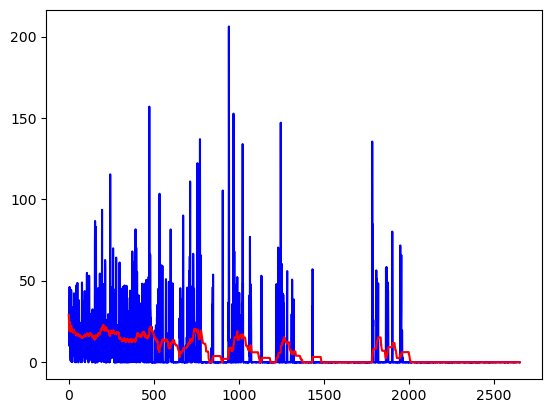

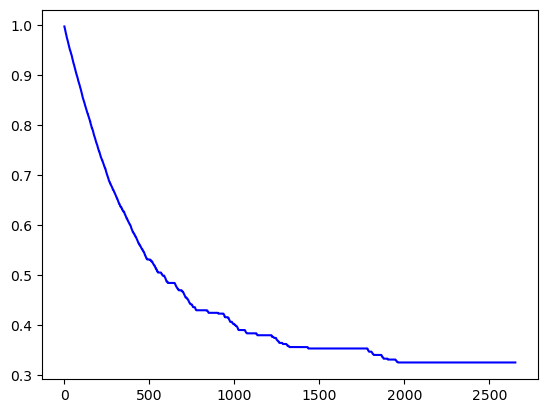

In [9]:
#Plot rewards over episodes
import matplotlib.pyplot as plt
print(len(rewards_over_episodes))
plt.plot(list(range(len(rewards_over_episodes))), rewards_over_episodes, color='blue')

#plot moving average
moving_average = []
for i in range(len(rewards_over_episodes)):
    if i < 50:
        moving_average.append(np.mean(rewards_over_episodes[:i+1]))
    else:
        moving_average.append(np.mean(rewards_over_episodes[i-50:i+1]))
    
plt.plot(list(range(len(rewards_over_episodes))), moving_average, color='red')
plt.show()
plt.plot(list(range(len(epsilon_values))), epsilon_values, color='blue')
plt.show()


# Model play the game

In [ ]:
env = gym.make('CarRacing-v2', render_mode='human')
episode = 900
ai_agent = CarRacingAgent()
ai_agent.load('./save/episode_900.h5')

for e in range(episode):
    init_state, obs_info = env.reset()
    init_state = process_state(init_state)

    total_reward = 0
    punishment_counter = 0
    state_frame_stack_queue = deque([init_state]*ai_agent.frame_stack_num, maxlen=ai_agent.frame_stack_num)
    time_frame_counter = 1
    
    while True:
        env.render()

        current_state_frame_stack = deque_to_stack(state_frame_stack_queue)
        act_values = ai_agent.model.predict(current_state_frame_stack, verbose=0)
        action = ai_agent.action_space[np.argmax(act_values[0])]
        next_state, reward, done, info, _ = env.step(action)

        total_reward += reward

        next_state = process_state(next_state)
        state_frame_stack_queue.append(next_state)

        if done:
            print('Episode: {}/{}, Scores(Time Frames): {}, Total Rewards: {:.2}'.format(e+1, 400, time_frame_counter, float(total_reward)))
            break
        time_frame_counter += 1

ValueError: in user code:

    File "c:\Users\ultra\anaconda3\lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\ultra\anaconda3\lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\ultra\anaconda3\lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\ultra\anaconda3\lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\ultra\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\ultra\anaconda3\lib\site-packages\keras\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_2" is incompatible with the layer: expected shape=(None, 96, 96, 3), found shape=(32, 96, 3)


: 